In [1]:
import tensorflow_core as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import pandas as pd
import seaborn as sb
import scipy as sp
import sklearn.preprocessing as skp
import sklearn.model_selection as skm

import sys
np.set_printoptions(threshold=sys.maxsize)

In [2]:
red_wines = pd.read_csv("./winequality-red.csv")

x_dataset = red_wines.drop(\
    ["quality"], axis=1).to_numpy()
y_dataset =  red_wines["quality"].to_numpy()

x_train, x_test, y_train, y_test = \
    skm.train_test_split(\
         x_dataset, \
         y_dataset, \
         random_state = 0, test_size = 0.15)

scaler = skp.StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [3]:
def plot_pie_chart(x_dataset, y_dataset):
    clusters = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    clusters_label = np.array(\
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

    for i in range(x_dataset.shape[0]):
        clusters[int(y_dataset[i]) - 1] += 1

    colors = sb.color_palette("Paired", 10)
    
    labels = ['{0:02d} - {2:04d} units ({1:1.2f} %)'.format(i,j, k) \
        for i,j, k in zip(clusters_label, \
           100.*clusters/clusters.sum(),
           clusters)]

    patches, texts = plt.pie(clusters, colors=colors, radius=1.25)

    sorted_zip = np.column_stack(\
         (patches, labels, clusters, clusters_label))

    sorted_zip = sorted_zip[np.apply_along_axis(lambda x: x[2], 1, sorted_zip).argsort()[::-1]]

    plt.legend(sorted_zip[:, 0], sorted_zip[:, 1], bbox_to_anchor=(1.9,1.0), \
        loc="upper right", fontsize=10)

    plt.show()
    

TRAINNING SIZE 1359 units


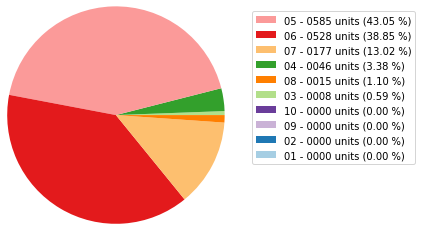

In [4]:
print(f"TRAINNING SIZE {x_train.shape[0]} units")
plot_pie_chart(x_train, y_train)

TESTING SIZE 240 units


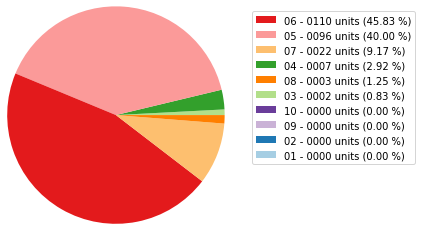

In [5]:
print(f"TESTING SIZE {x_test.shape[0]} units")
plot_pie_chart(x_test, y_test)

In [6]:
num_features = x_train.shape[1]
num_labels = 10 # 10 quality

def convert_to_one_hot(y_dataset, num_labels):
    y_one_hot = np.array([-99.] * num_labels)
    for val in y_dataset:
        one_hot = np.array(\
            [0.] * int(val - 1) + [1.] + [0.] * int(num_labels - val))
        
        y_one_hot = np.vstack((y_one_hot, one_hot))
    
    return y_one_hot[1:] # remove first dummy

y_train_one_hot = convert_to_one_hot(y_train, num_labels)
y_test_one_hot = convert_to_one_hot(y_test, num_labels)

In [7]:
X = tf.placeholder(tf.float32, shape=[None, num_features], name="x")
Y = tf.placeholder(tf.float32, shape=[None, num_labels], name="y")

# same idea as (x_1 * w_1) + w_0 
w = tf.Variable(tf.zeros([num_features, num_labels]), name="w", trainable=True)
b = tf.Variable(tf.zeros([num_labels]), name="b", trainable=True)

reg_lambda = tf.placeholder(tf.float32)

def model(X, w, b):
    logits = tf.add(tf.matmul(X, w), b)
    
    sum_dimension = 1 # quality for each feature
    
    sum_logits = tf.reduce_sum(\
        tf.reduce_sum(\
            tf.exp(logits), sum_dimension))
    
    return tf.divide(tf.exp(logits), sum_logits)

y_model = model(X, w, b)

In [8]:
learning_rate = 0.001
training_epochs = 1000

cost = tf.add(\
    -tf.reduce_mean(Y * tf.log(y_model)),\
    tf.multiply(reg_lambda, tf.abs(\
       tf.reduce_sum(tf.add(w, b)))))
train_op = tf.train.GradientDescentOptimizer(learning_rate)\
    .minimize(cost)

In [9]:
def make_prediction(x, w, b):
    logits = np.add(np.matmul(x, w), b)
    
    sum_dimension = 1 # quality for each feature
    
    sum_logits = np.sum(\
        np.sum(\
            np.exp(logits), axis=sum_dimension))
    
    return np.argmax(\
        np.divide(np.exp(logits), sum_logits),\
            sum_dimension) + 1

def compare_dif_result(x1, x2):
    
    total_same_val = 0
    for i, x in enumerate(x1):
        if x1[i].astype(np.int32) == \
            x2[i].astype(np.int32):
            total_same_val += 1
    
    return total_same_val / x1.shape[0]


In [10]:
max_dif = 0.0 # imposible large cost
final_w = np.zeros((num_features, num_labels))
final_b = np.zeros((num_labels))

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

train_size = x_train.shape[0]
batch_size = 100

for lamb_val in np.linspace(0, 1, 100):
    for epoch in range(training_epochs):
        total_batch = train_size // batch_size
        for step in range(total_batch):
            offset = (step * batch_size) % train_size
            batch_xs = x_train[offset:(offset + batch_size)]
            batch_labels = y_train_one_hot[offset:(offset + batch_size)]
            sess.run(train_op, \
                         feed_dict={\
                            X: batch_xs, \
                            Y: batch_labels,
                            reg_lambda: lamb_val})

    testing_dif = compare_dif_result(y_test, \
         make_prediction(x_test, sess.run(w), sess.run(b)))
    
    print(f"Lambda: {lamb_val}")
    print(f"Testing accuracy: {testing_dif}")
    print("===========")

    if testing_dif >= max_dif:
        max_dif = testing_dif
        final_w = sess.run(w)
        final_b = sess.run(b)

        # print(final_w)
        # print(final_b)
    
    w.assign(tf.zeros([num_features, num_labels]))
    b.assign(tf.zeros([num_labels]))
sess.close()                    

Lambda: 0.0
Testing accuracy: 0.575
Lambda: 0.010101010101010102
Testing accuracy: 0.5791666666666667
Lambda: 0.020202020202020204
Testing accuracy: 0.6041666666666666
Lambda: 0.030303030303030304
Testing accuracy: 0.6291666666666667
Lambda: 0.04040404040404041
Testing accuracy: 0.6333333333333333
Lambda: 0.05050505050505051
Testing accuracy: 0.6333333333333333
Lambda: 0.06060606060606061
Testing accuracy: 0.625
Lambda: 0.07070707070707072
Testing accuracy: 0.625
Lambda: 0.08080808080808081
Testing accuracy: 0.6291666666666667
Lambda: 0.09090909090909091
Testing accuracy: 0.6333333333333333
Lambda: 0.10101010101010102
Testing accuracy: 0.6375
Lambda: 0.11111111111111112
Testing accuracy: 0.6375
Lambda: 0.12121212121212122
Testing accuracy: 0.6375
Lambda: 0.13131313131313133
Testing accuracy: 0.6375
Lambda: 0.14141414141414144
Testing accuracy: 0.6333333333333333
Lambda: 0.15151515151515152
Testing accuracy: 0.6333333333333333
Lambda: 0.16161616161616163
Testing accuracy: 0.633333333333

In [11]:
from sklearn.metrics import confusion_matrix

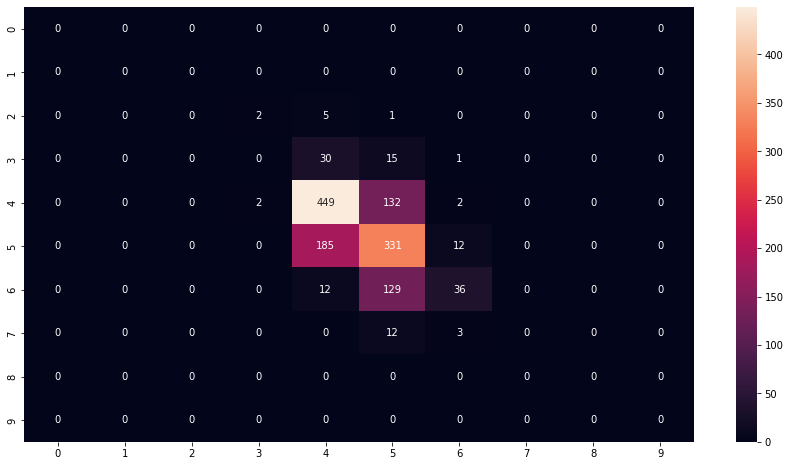

In [28]:
cm = confusion_matrix(y_train, \
    make_prediction(x_train, final_w, final_b), \
    labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.figure(figsize = (15,8))
sb.heatmap(cm, annot=True, fmt='g')
plt.show()

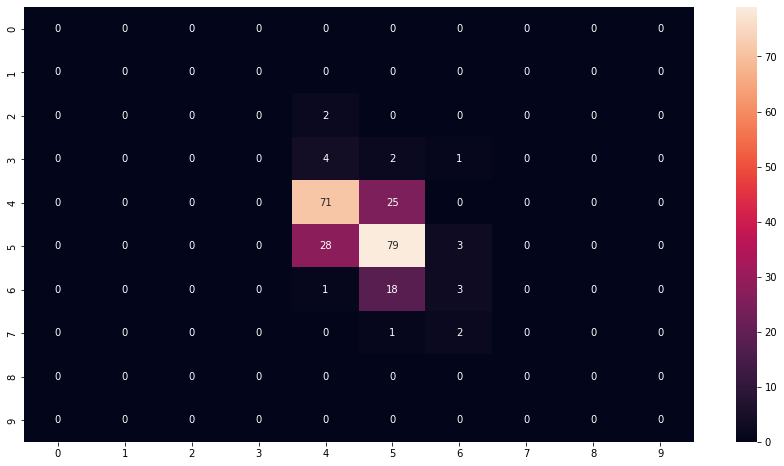

In [29]:
cm = confusion_matrix(y_test, \
    make_prediction(x_test, final_w, final_b), \
    labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.figure(figsize = (15,8))
sb.heatmap(cm, annot=True, fmt='g')
plt.show()